<a href="https://colab.research.google.com/github/paulcodrea/reddit_humor/blob/main/Humour_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd

### Defining methods useful for scraping the Reddit threads


In [24]:
def scrape_url(url, pages=0):
  """ 
  Scrapes a url and returns a list.
  """

  resp = requests.get(url=url, headers = {'User-agent': 'Humour detection bot'}, params = {'limit': '100'})
  data = resp.json()
  ret = []
  ret.append(data)
  
  # if more than 100 data points are needed:
  if pages != 0:
    for i in range(pages):
      after_param = data['data']['after'] 
      data = requests.get(url=url, headers = {'User-agent': 'Humour detection bot'}, params = {'after': after_param, 'limit': '100'})
      data_2 = data.json()
      ret.append(data_2)
      data = data_2

  return ret

def make_list_from_json(json_list):
  """
  Makes a list from a json list.
  """

  ret = []
  for collection in json_list:
    collection_list = collection['data']['children']
    for joke_index in range(len(collection_list)):
      ret.append(collection_list[joke_index]['data'])
  return ret

def transform_data(data):
  """ 
  Transforms data to a dataframe. Ans only keeps the columns that are needed.
  """
  df = pd.DataFrame(data)
  ret = pd.DataFrame()

  ret['title'] = df['title']
  ret['selftext'] = df['selftext']
  ret['ups'] = df['ups']
  ret['downs'] = df['downs']
  ret['upvote_ratio'] = df['upvote_ratio']
  ret['total_awards_received'] = df['total_awards_received']

  return ret

def preprocess(data):
  """
  Preprocesses data to concatenate title and punchline into one string.
  """

  data['joke'] = ''
  for joke_index in range(len(data)):
    title = data['title'][joke_index]
    separator = ' '
    if title[len(title) - 1].isalpha():
        separator = '. '
    data['joke'][joke_index] = data['title'][joke_index] + separator + data['selftext'][joke_index] 
    joke = data['joke'][joke_index]
    if joke[len(joke) - 1].isalpha():
      data['joke'][joke_index] = joke + '.'

  return data

# Scraping r/dadjokes


In [3]:
url = "https://www.reddit.com/r/dadjokes.json"
data = scrape_url(url, 100)
data = make_list_from_json(data)

### Save only important columns in dataframe

In [4]:
clean_df = transform_data(data)

### Plot the stats of the reddit jokes

Number of jokes with upvotes different from zero:  8960
Number of jokes with no engagement:  568
Average number of upvotes:  228.58354324097397
Average upvote ratio:  0.842445424013434


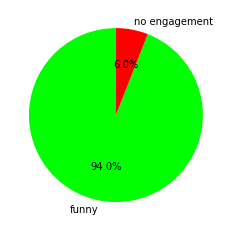

In [33]:
# print out as a pie chart how many jokes are funny or not
from matplotlib import pyplot as plt

# calculate number of posts with upvotes different grater than downvotes
funny = clean_df[clean_df['ups'] > clean_df['downs']]
# not_funny = clean_df[clean_df['ups'] <= clean_df['downs']]
no_engagement = len(clean_df[(clean_df['ups'] == 0) & (clean_df['downs'] == 0)])


#calculate how many have only upvotes and zero downvotes
upvotes_count = downvotes_count = 0
for index in range(len(clean_df)):
    if clean_df['ups'][index] > 0:
        upvotes_count += 1

print("Number of jokes with upvotes different from zero: ", upvotes_count)
print("Number of jokes with no engagement: ", no_engagement)

treshhold_ups = clean_df['ups'].mean()
print("Average number of upvotes: ", treshhold_ups)
threshold_ratio = clean_df['upvote_ratio'].mean()
print("Average upvote ratio: ", threshold_ratio)


funny_percentage = len(funny) / len(clean_df) * 100
no_engagement_percentage = no_engagement / len(clean_df) * 100


plt.figure(figsize=(4,4))
plt.pie([funny_percentage, no_engagement_percentage], labels=['funny', 'not funny'], autopct='%1.1f%%', colors=['green', 'red'])
plt.show()

Experimenting to find a threshold 

In [6]:
unfunny_but_awarded = 0
funny = 0
count = 0
jokes_dataset = pd.DataFrame()
for index in range(len(clean_df)):

  if clean_df['ups'][index] > treshhold_ups and clean_df['upvote_ratio'][index] > threshold_ratio:
    jokes_dataset = jokes_dataset.append(clean_df.iloc[count])
    count = count + 1
    funny = funny + 1



print('total ', len(clean_df))
print('not that funny but have awards ', unfunny_but_awarded)
print('funny ', funny)
print('funny ratio ', funny/len(clean_df))

total  9528
not that funny but have awards  0
funny  683
funny ratio  0.07168345927791772


In [7]:
# add one more column to jokes_dataset with length of selftext
jokes_dataset['title_length'] = jokes_dataset['title'].apply(len)
jokes_dataset['selftext_length'] = jokes_dataset['selftext'].apply(len)
print("The highest length of title is ", jokes_dataset['title_length'].max())
print("The highest length og the joke is: ", jokes_dataset['selftext_length'].max())

The highest length of title is  260
The highest length og the joke is:  1778


In [8]:
# save jokes_dataset in a csv file
jokes_dataset.to_csv(f'reddit_funny_dadjokes({len(jokes_dataset)}).csv')

# Scraping r/badjokes


In [9]:
# Get reddit /r/badjokes data
url = "https://www.reddit.com/r/badjokes.json"
data_neg = scrape_url(url, 5)
data_neg = make_list_from_json(data_neg)

### Save only important columns in dataframe

In [10]:
badjokes_dataset = transform_data(data_neg)

In [11]:
print(len(badjokes_dataset))

600


In [12]:
# save jokes_dataset in a csv file
badjokes_dataset.to_csv(f'reddit_badjokes({len(badjokes_dataset)}).csv')

### Create a single dataframe with all content and 0/1 

In [22]:
# Create one more column for jokes_dataset filles with 1
jokes_dataset['funny'] = 1
badjokes_dataset['funny'] = 0

                                               title  \
0                 What's so good about Soviet Ubers?   
1                             Why was 9 afraid of 7?   
2     What's a candle's favorite Keanu Reeves movie?   
3  No-one in the Government has played Hospital T...   
4           What is the most pathetic kind of shape?   

                         selftext  ups  downs  upvote_ratio  \
0          They're always Russian  194      0          1.00   
1  7 was a registered 6 offender.  385      0          0.99   
2                       John Wick  120      0          1.00   
3                                   51      0          0.97   
4                  \n\nRektangles   68      0          0.99   

   total_awards_received  funny  
0                      3      0  
1                      3      0  
2                      0      0  
3                      0      0  
4                      0      0  


### Data Pre-processing - WIP

### and save the final_df with jokes.

In [ ]:
jokes_dataset = preprocess(jokes_dataset)
badjokes_dataset = preprocess(badjokes_dataset)

# create final_df with jokes_dataset specific columns
final_df = pd.DataFrame()
final_df['joke'] = jokes_dataset['joke']
final_df['funny'] = jokes_dataset['funny']

#concat to final_df with badjokes_dataset specific columns
final_df = final_df.append(badjokes_dataset, ignore_index=True)
# remove title, selftext, ups, downs, upvote_ratio, total_awards_received
final_df = final_df.drop(['title', 'selftext', 'ups', 'downs', 'upvote_ratio', 'total_awards_received'], axis=1)

In [29]:
# save final_df in a csv file
final_df.to_csv(f'final_jokes({len(final_df)}).csv')

### Experiment with similarity scores

In [30]:
normalised_jokes = []
for joke_index in range(len(jokes_dataset)):
  if jokes_dataset['title_length'][joke_index] + jokes_dataset['selftext_length'][joke_index] < 200:
    normalised_jokes.append(joke_index)
print(len(normalised_jokes))

651


In [31]:
from difflib import SequenceMatcher

max = 0
index_similar = 0
jokes_dataset['similarity'] = ''
for joke_index in range(len(jokes_dataset)):
  title = jokes_dataset['title'][joke_index]
  text = jokes_dataset['selftext'][joke_index]

  title_words = title.split()
  text_words = text.split()
  final_score = 0
  for title_word in title_words:
    for text_word in text_words:
      s = SequenceMatcher(None,title_word,text_word)
      match_freq = s.ratio()
      final_score += 1
  jokes_dataset['similarity'][joke_index] = final_score
  if final_score > max and joke_index in normalised_jokes:
    index_similar = joke_index
    max = final_score
print(jokes_dataset['joke'][index_similar])


C:\Users\paulc\AppData\Local\Temp/ipykernel_20360/3608984461.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jokes_dataset['similarity'][joke_index] = final_score


I went to get pizza the other day and they asked if I wanted it cut into eight slices. I told them there’s no way I can eat eight slices in one sitting and had them cut it into four.
